In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [72]:
game_stats = pd.read_csv('../csv/game_stats.csv')
game_stats["totalGoals"] = game_stats["home_goals"] + game_stats["away_goals"]
game_stats = game_stats[game_stats["totalGoals"] < 10]  # remove outliers 99% of games will be kept
del game_stats["Unnamed: 0"]
del game_stats["home_goals"]
del game_stats["away_goals"]
del game_stats["home_powerPlayGoals"]
del game_stats["away_powerPlayGoals"]
del game_stats["home_powerPlayOpportunities"]
del game_stats["away_powerPlayOpportunities"]

game_stats = game_stats.drop_duplicates()
game_stats = game_stats.dropna()

game_stats

,home_pim,home_shots,home_powerPlayPercentage,home_faceOffWinPercentage,home_blocked,home_takeaways,home_giveaways,home_hits,away_pim,away_shots,away_powerPlayPercentage,away_faceOffWinPercentage,away_blocked,away_takeaways,away_giveaways,away_hits,totalGoals
2,10,29,0.0,68.2,17,5,2,23,12,15,33.3,31.8,8,6,4,23,6
5,10,27,0.0,51.6,13,8,16,45,4,40,40.0,48.4,4,3,9,22,4
9,4,41,50.0,41.4,18,4,10,24,4,15,50.0,58.6,11,4,9,13,7
10,2,46,50.0,45.6,9,8,12,29,6,39,0.0,54.4,13,6,6,20,7
11,2,24,66.7,57.1,7,3,19,23,6,34,0.0,42.9,15,9,9,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21383,4,32,0.0,52.6,15,5,9,29,8,19,0.0,47.4,23,6,7,33,4
21384,4,23,0.0,43.9,23,14,19,20,6,24,50.0,56.1,17,8,7,13,3
21386,9,32,0.0,63.6,13,4,12,27,9,37,0.0,36.4,17,7,10,27,7
21390,4,37,75.0,49.0,6,3,11,9,8,21,0.0,51.0,10,3,2,17,5


In [73]:
col_names = [col for col in game_stats.columns]


originalGoals = game_stats["totalGoals"]

# z = (x-mean)/std
# x = (z*std)+mean

original_mean = game_stats.mean()
original_std = game_stats.std()

game_stats_normalized =(game_stats-original_mean)/original_std
game_stats = game_stats_normalized
game_stats["totalGoals"] = originalGoals

features = np.array(game_stats.loc[:, game_stats.columns != 'totalGoals'],  dtype='float32')
targets = np.array(game_stats['totalGoals'], dtype='float32')


x_train = features[:int(features.shape[0] * 0.8)]
t_train = targets[:int(targets.shape[0] * 0.8)]

x_test = features[int(features.shape[0] * 0.8):]
t_test = targets[int(targets.shape[0] * 0.8):]


In [102]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
onehot_encoder = OneHotEncoder(sparse=False)
from sklearn.datasets import load_iris

def loss(X, Y, W):
    """
    Y: onehot encoded
    """
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def gradient(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + 2 * mu * W
    return gd

def gradient_descent(X, Y, max_iter=100, eta=0.5, mu=0.01):
    """
    Very basic gradient descent algorithm with fixed eta and mu
    """
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
 
    tt = trange(max_iter)
    for _ in tt:
        W -= eta * gradient(X, Y_onehot, W, mu)
        step_lst.append(step)
        W_lst.append(W)
        e_loss = loss(X, Y_onehot, W)
        loss_lst.append(e_loss)
        tt.set_description(f'Loss: {e_loss:.3f}')

    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W

class Multiclass:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)

In [103]:
X = x_train
Y = t_train

# fit model
model = Multiclass()
model.fit(X, Y)

Loss: 2.225:  34%|███▍      | 34/100 [00:11<00:21,  3.03it/s]


KeyboardInterrupt: 

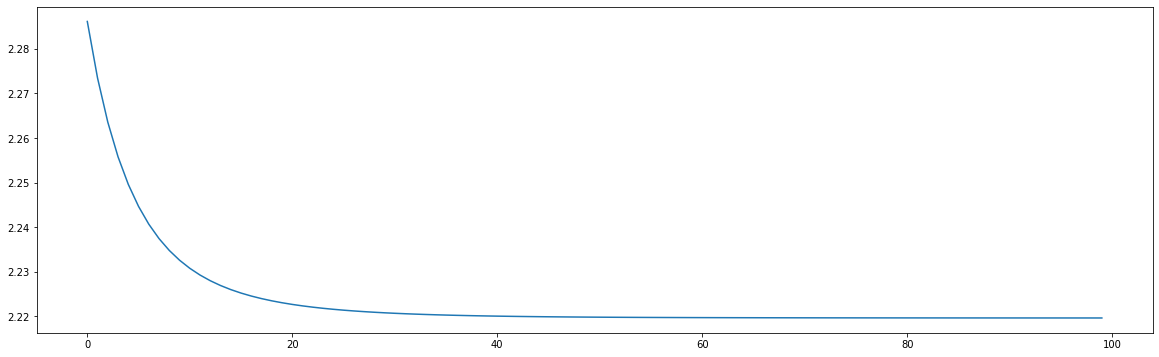

In [101]:
plt.rcParams["figure.figsize"] = (20, 6)
losses = model.loss_steps["loss"]
plt.plot(list(losses))

In [77]:
preds = model.predict(x_test)

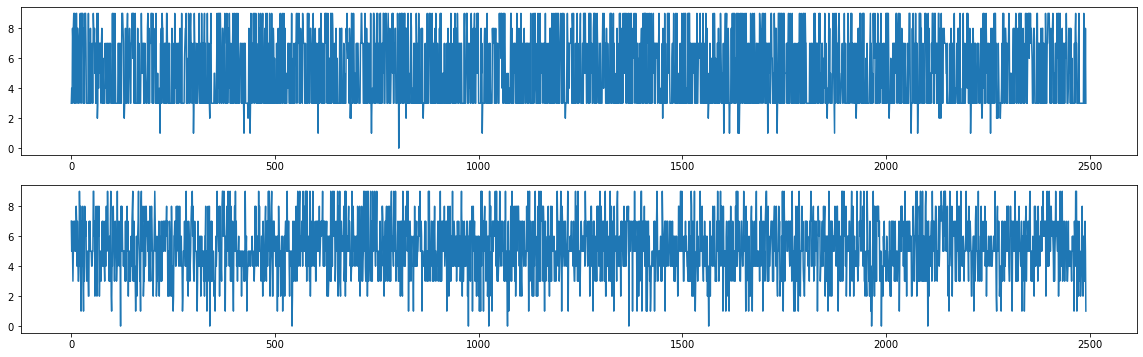

In [82]:
plt.subplot(211)
plt.plot(preds)

plt.subplot(212)
plt.plot(t_test)

array([[<AxesSubplot:title={'center':'Prediction Dist. (Train)'}>,
        <AxesSubplot:title={'center':'Target Dist. (Train)'}>]],
      dtype=object)

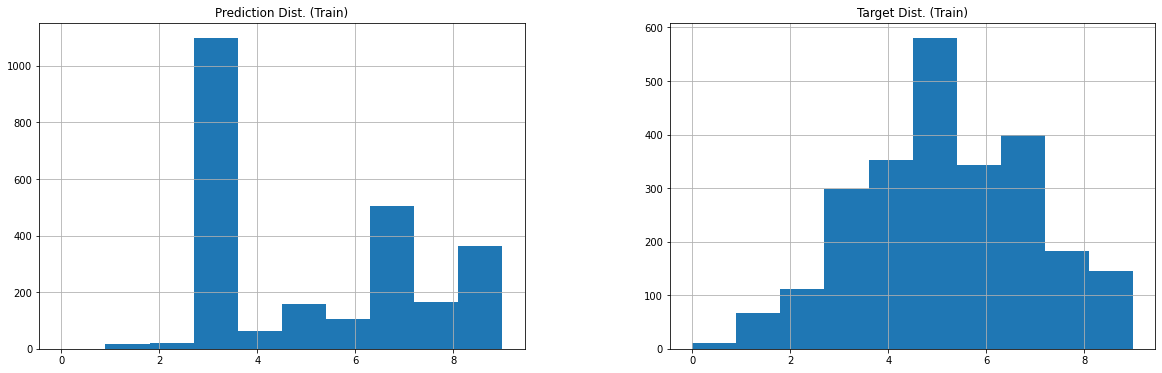

In [83]:
pred_and_targets_df = pd.DataFrame({'Prediction Dist. (Train)': preds, 'Target Dist. (Train)': t_test})
pred_and_targets_df.hist()